In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from radiomics import featureextractor
from scipy.stats import wilcoxon
from time import time
import matplotlib.pyplot as plt
import numpy.matlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.preprocessing import StandardScaler
import SimpleITK as sitk
import six
import trimesh
import numpy as np
from numpy import linalg
import os
import pywt
import pickle
import sys
from scipy.stats import linregress
import pandas as pd
import nrrd
from util import plot_correlation_heatmap
import logging

%matplotlib widget

In [3]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (25,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [4]:
vsharp_15t_dir = '/media/mts_dbs/3t_15t/sub/ctrl/15t/'
msmv_15t_dir = '/media/mts_dbs/3t_15t/sub/msmv/15t/'
roi_15t_dir = '/media/mts_dbs/3t_15t/sub/atlas_gm/15t/'
vsharp_15t_niis = sorted(os.listdir(vsharp_15t_dir))
msmv_15t_niis = sorted(os.listdir(msmv_15t_dir))
roi_15t_niis = sorted(os.listdir(roi_15t_dir))

vsharp_3t_dir = '/media/mts_dbs/3t_15t/sub/ctrl/3t/'
msmv_3t_dir = '/media/mts_dbs/3t_15t/sub/msmv/3t/'
roi_3t_dir = '/media/mts_dbs/3t_15t/sub/atlas_gm/3t/'
vsharp_3t_niis = sorted(os.listdir(vsharp_3t_dir))
msmv_3t_niis = sorted(os.listdir(msmv_3t_dir))
roi_3t_niis = sorted(os.listdir(roi_3t_dir))

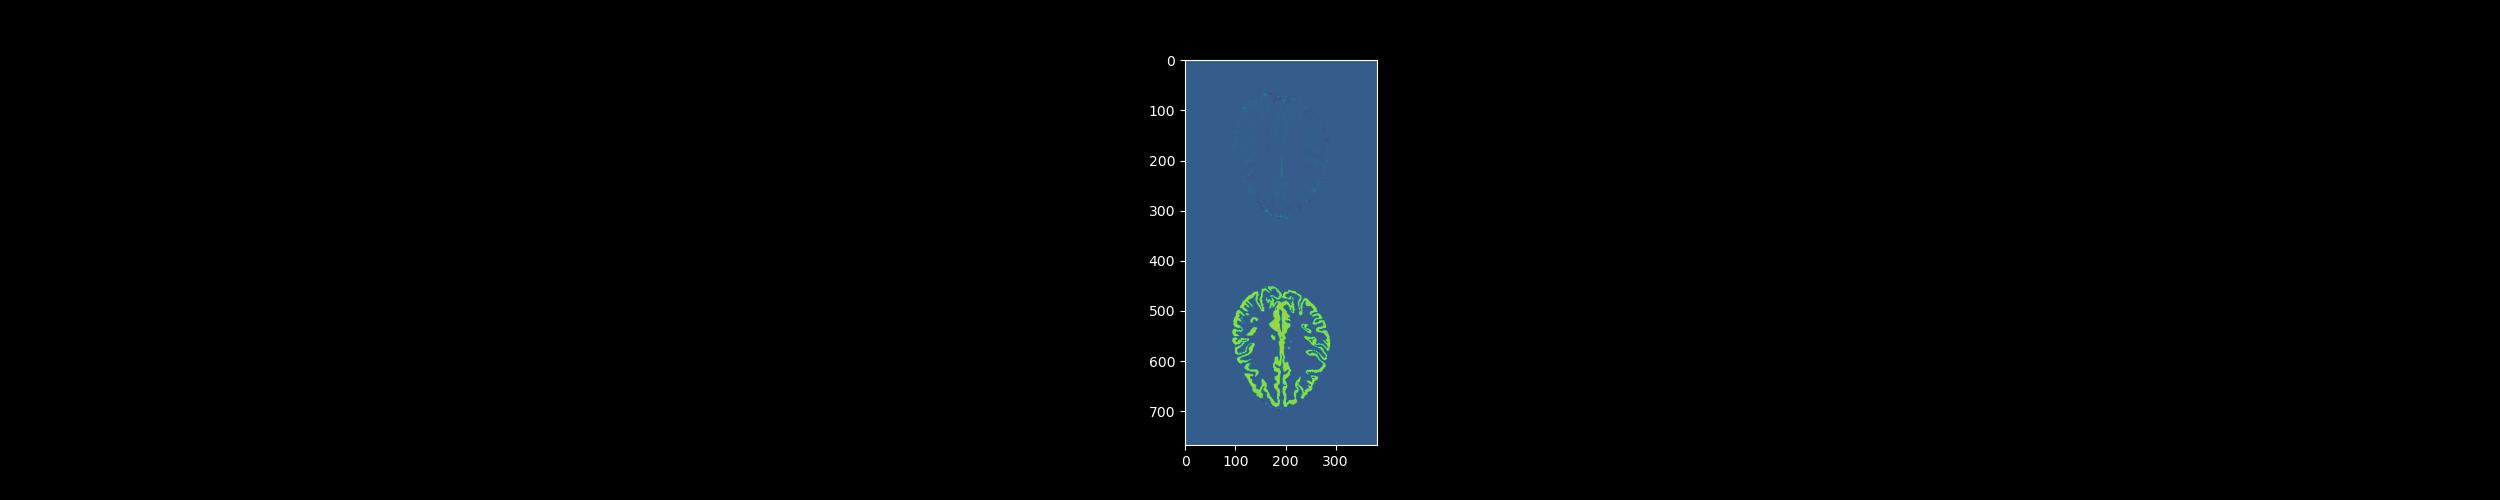

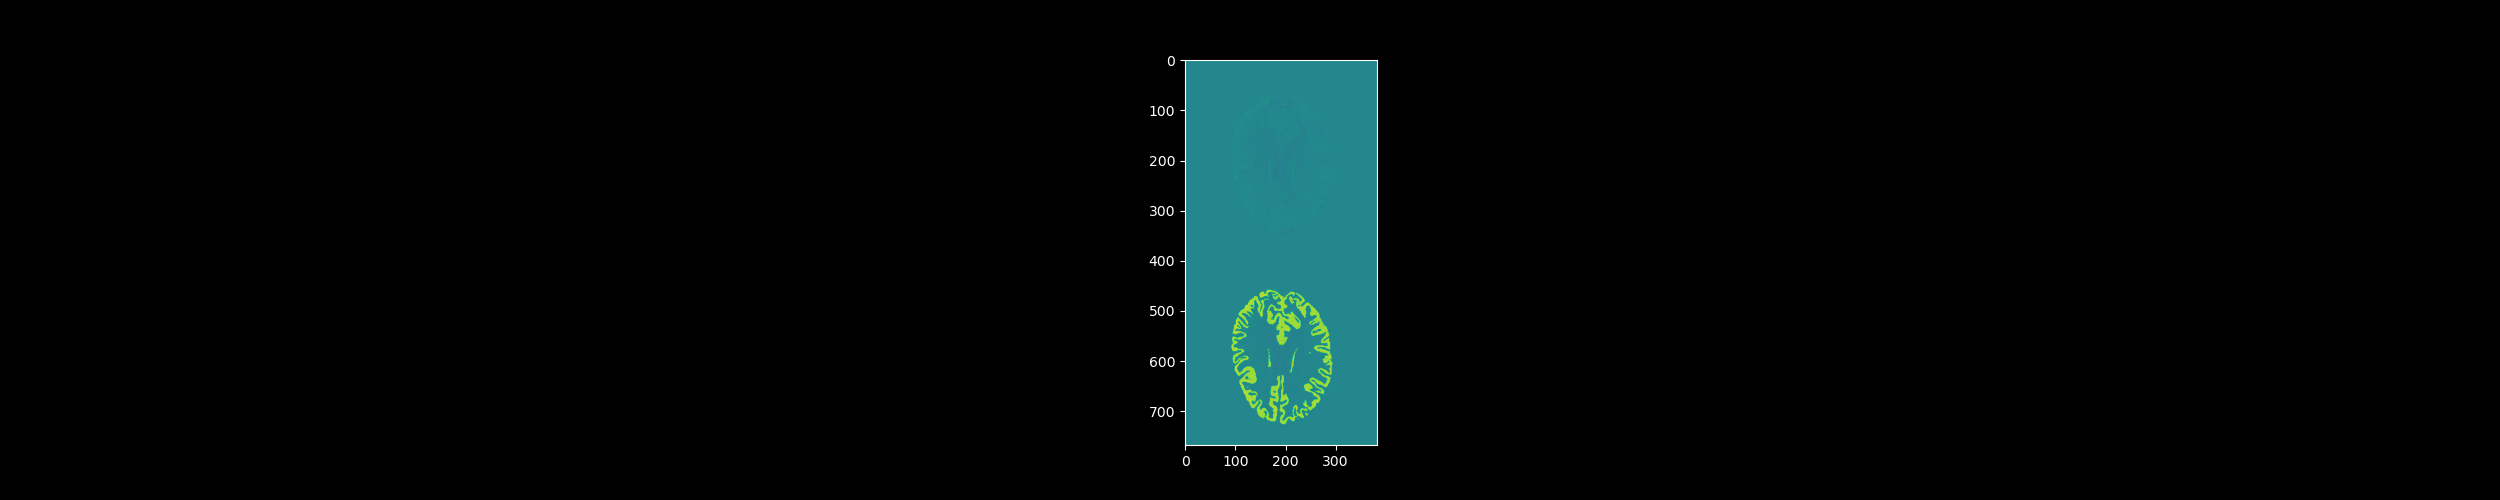

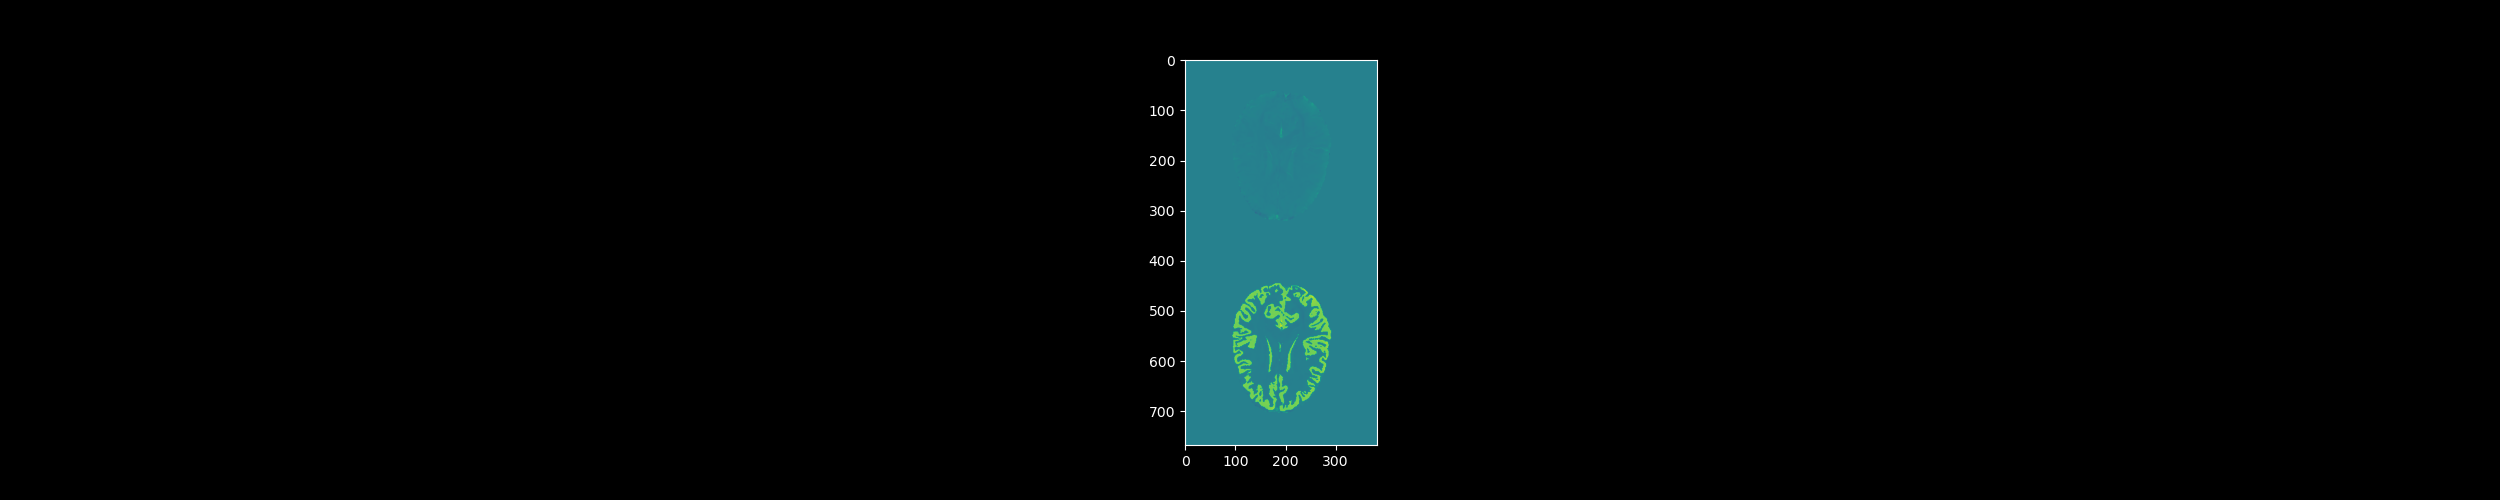

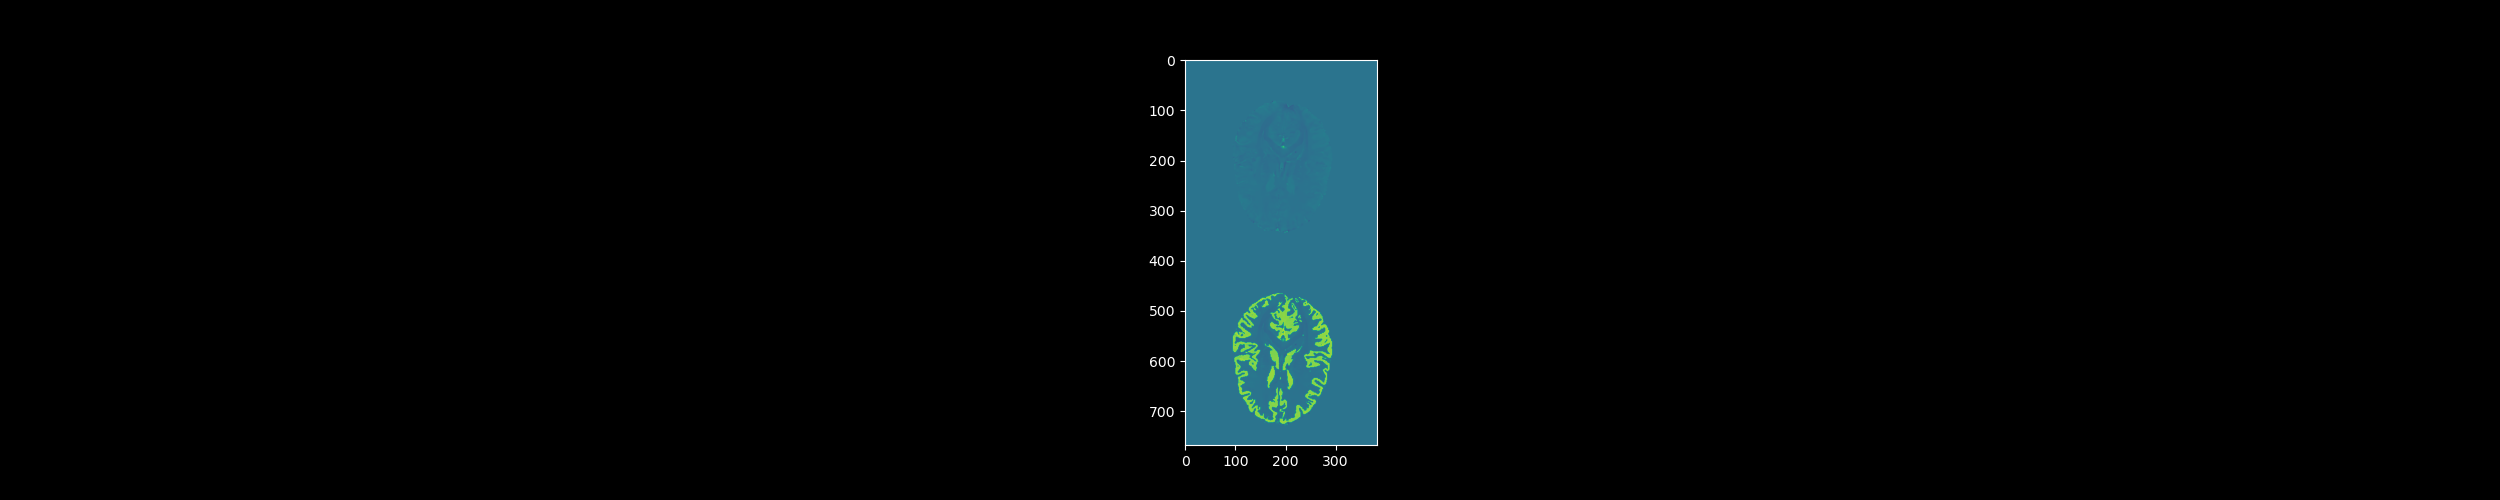

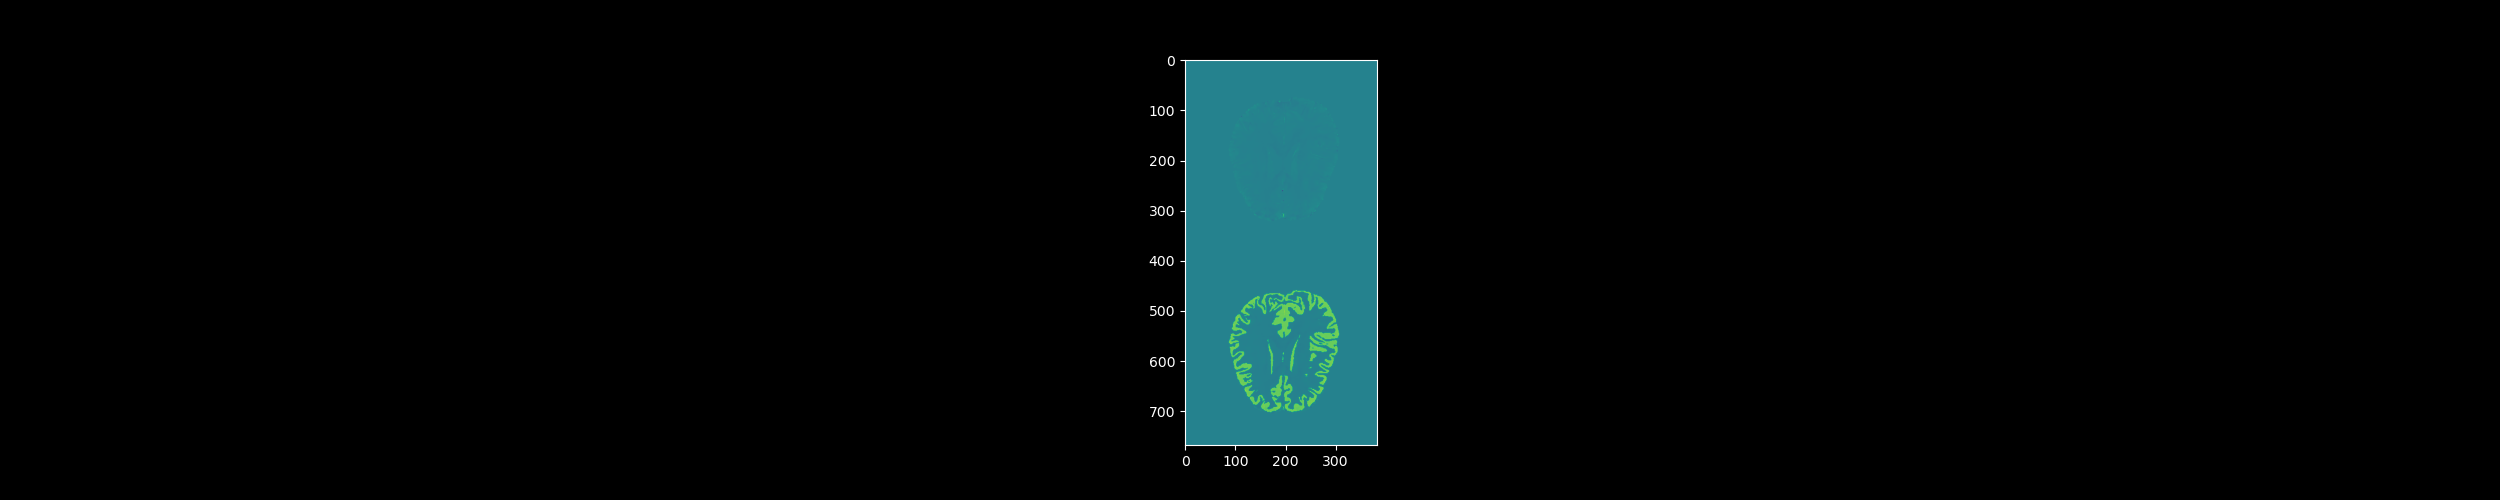

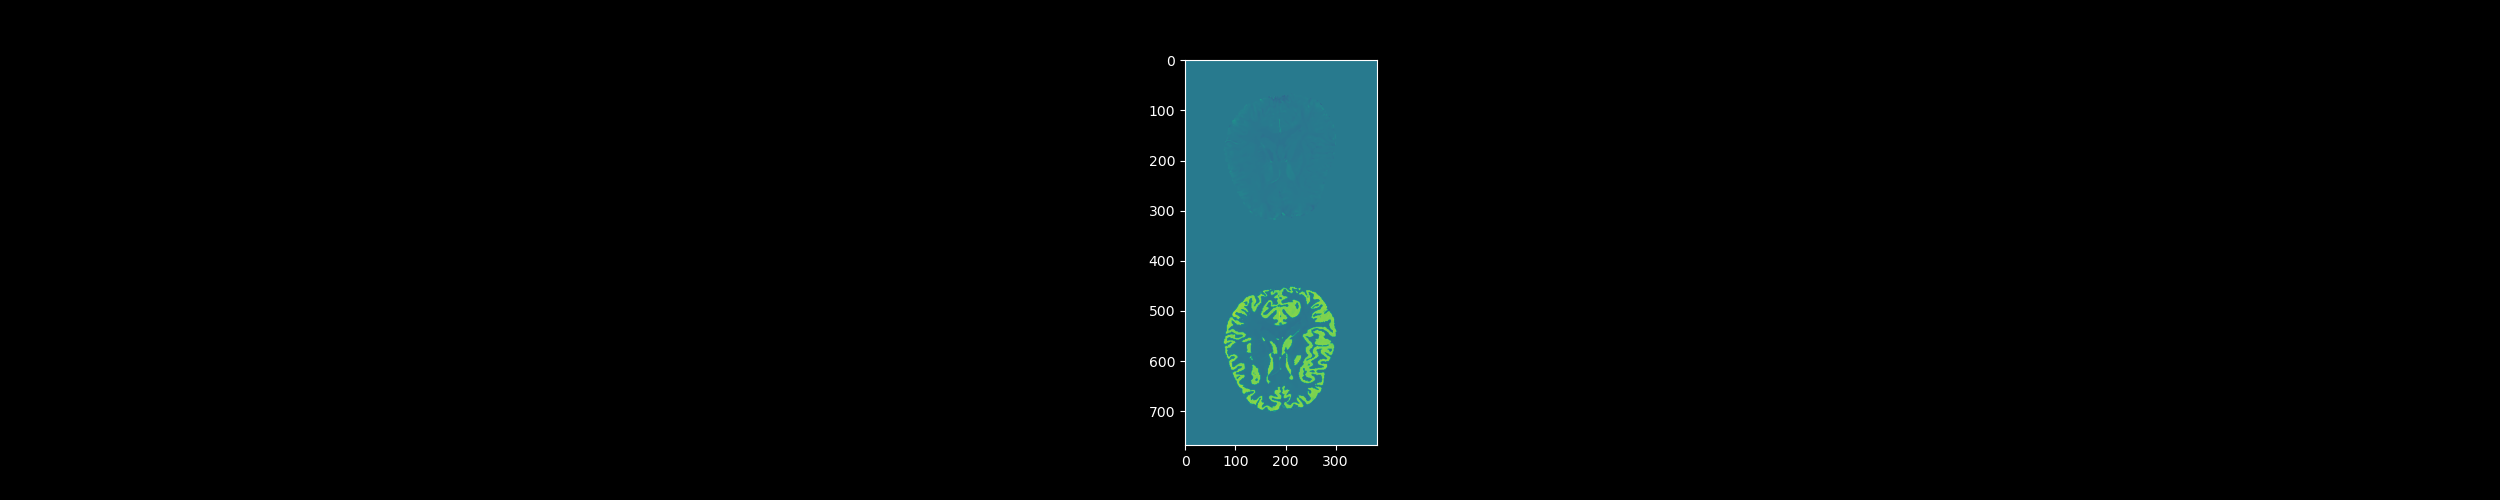

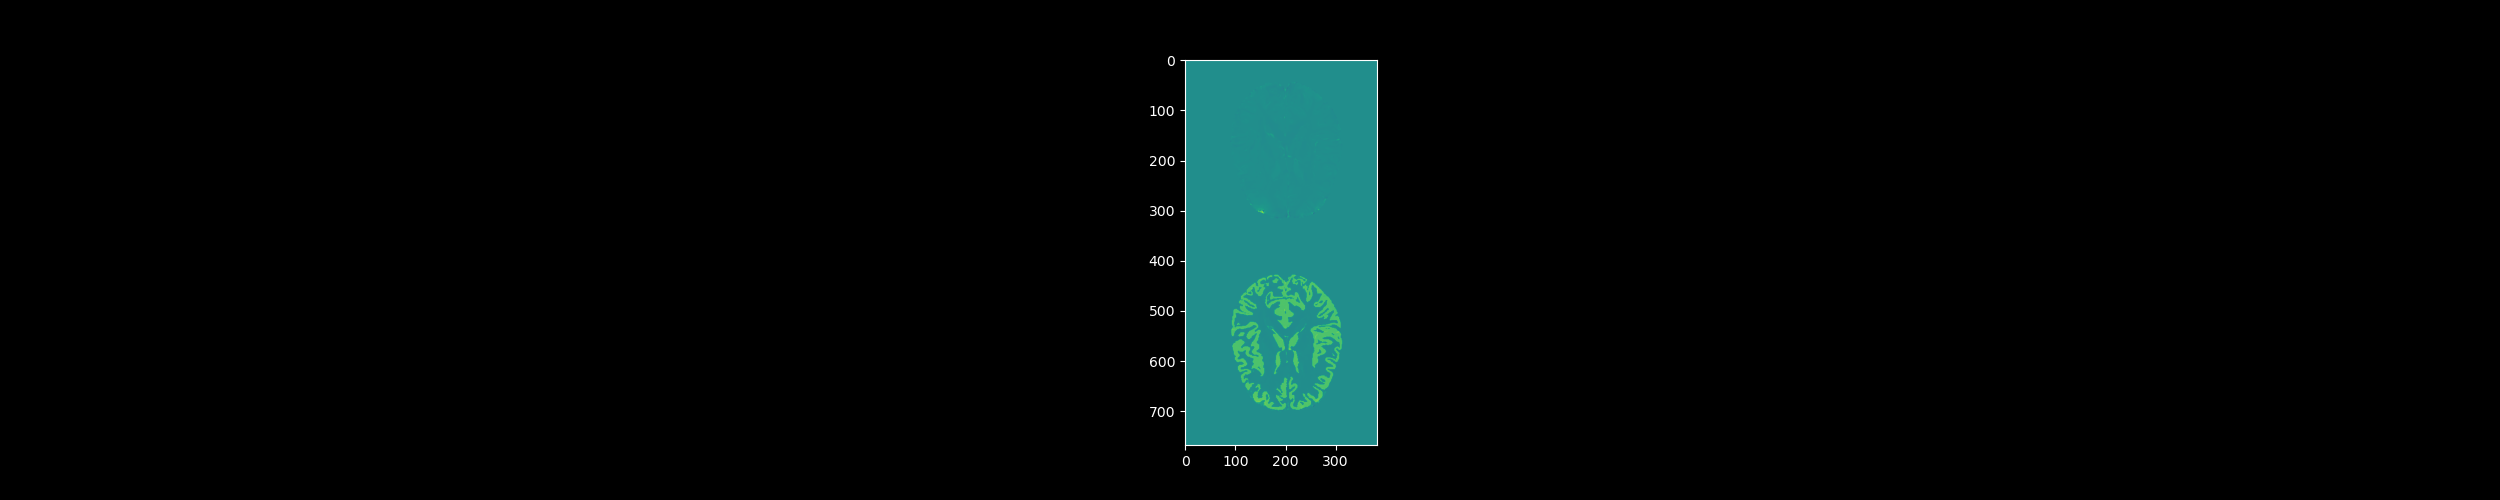

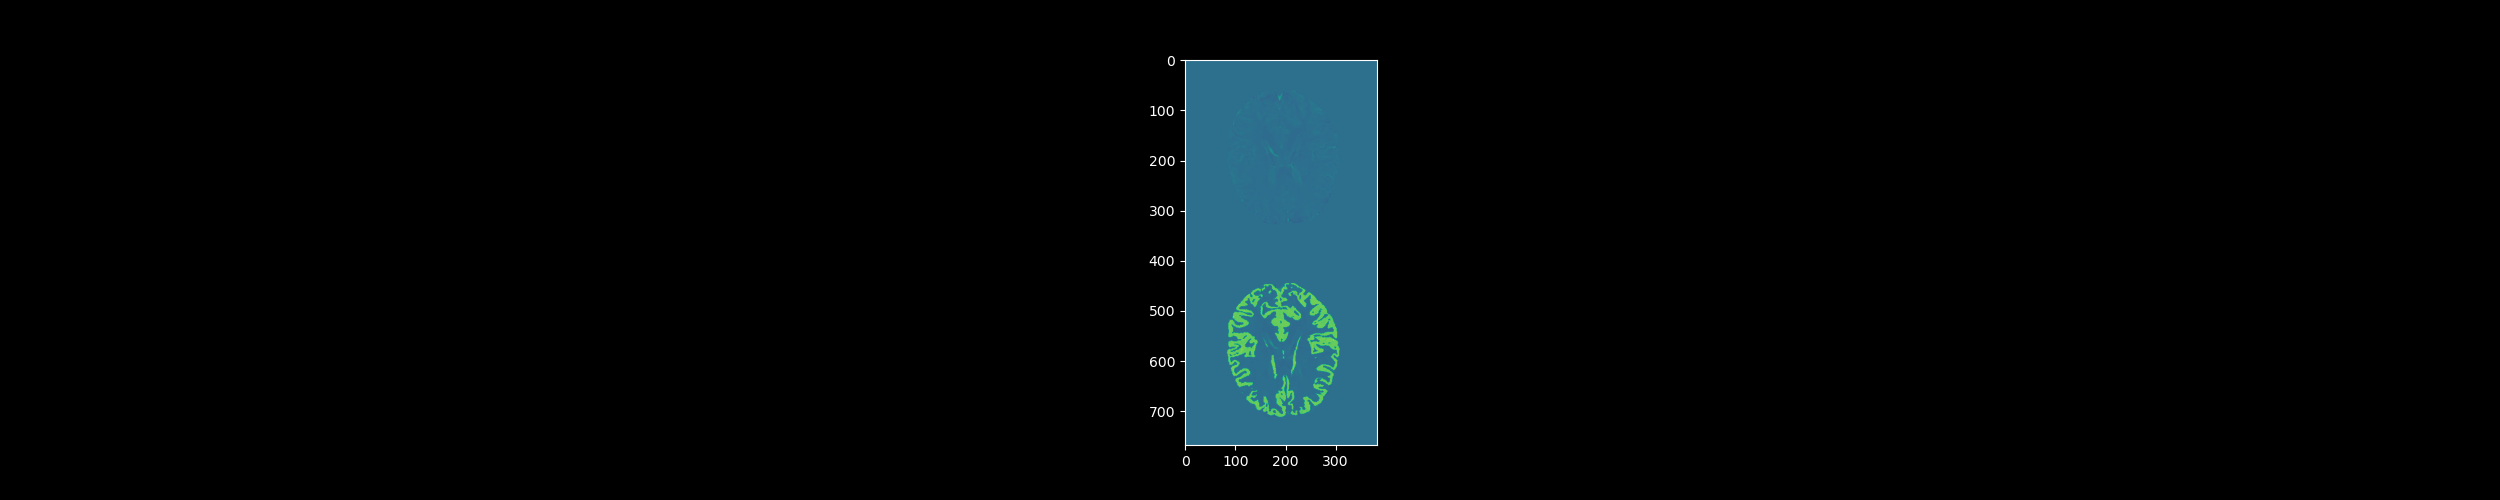

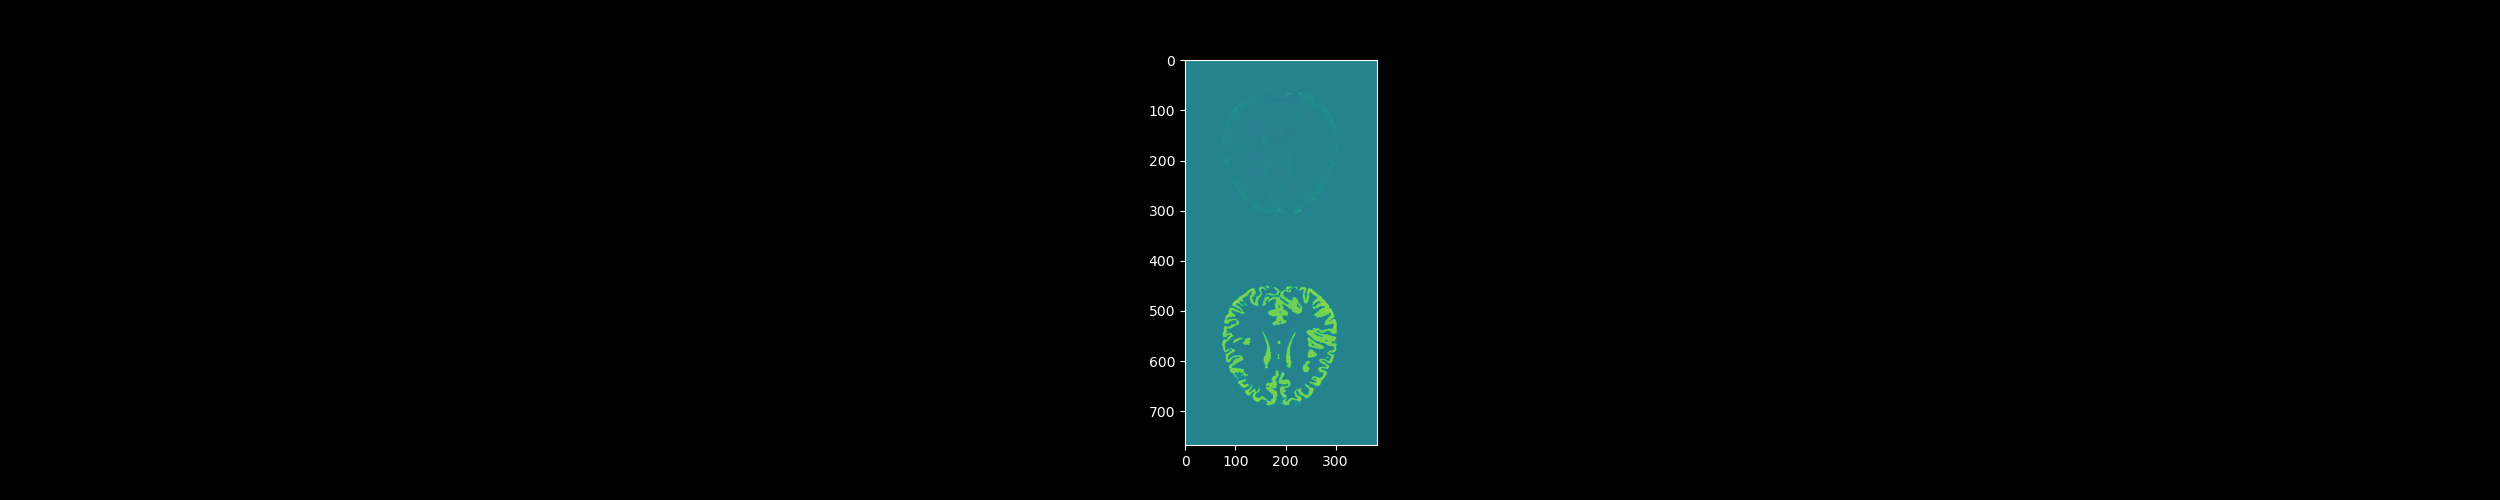

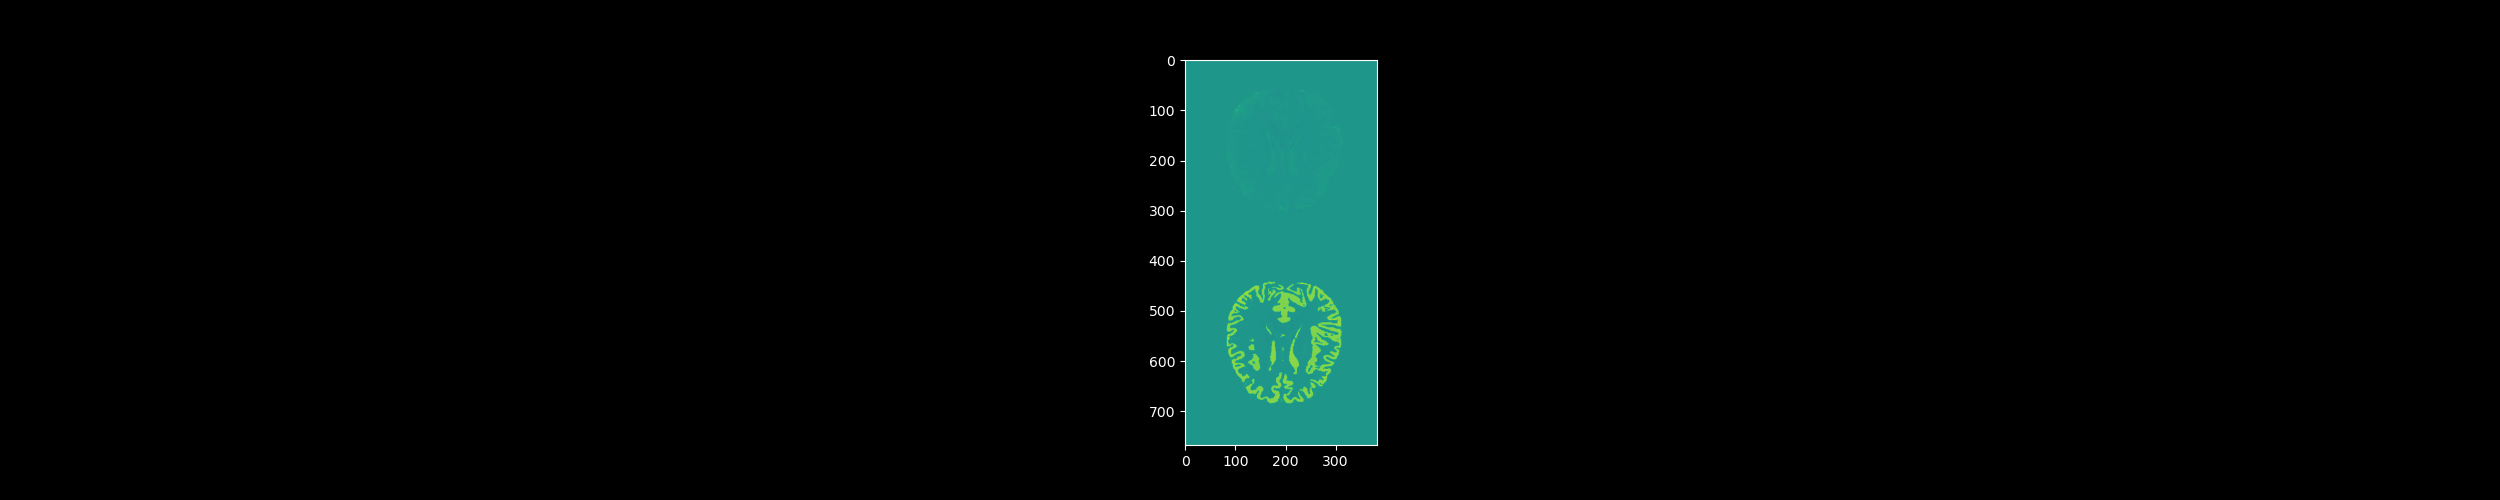

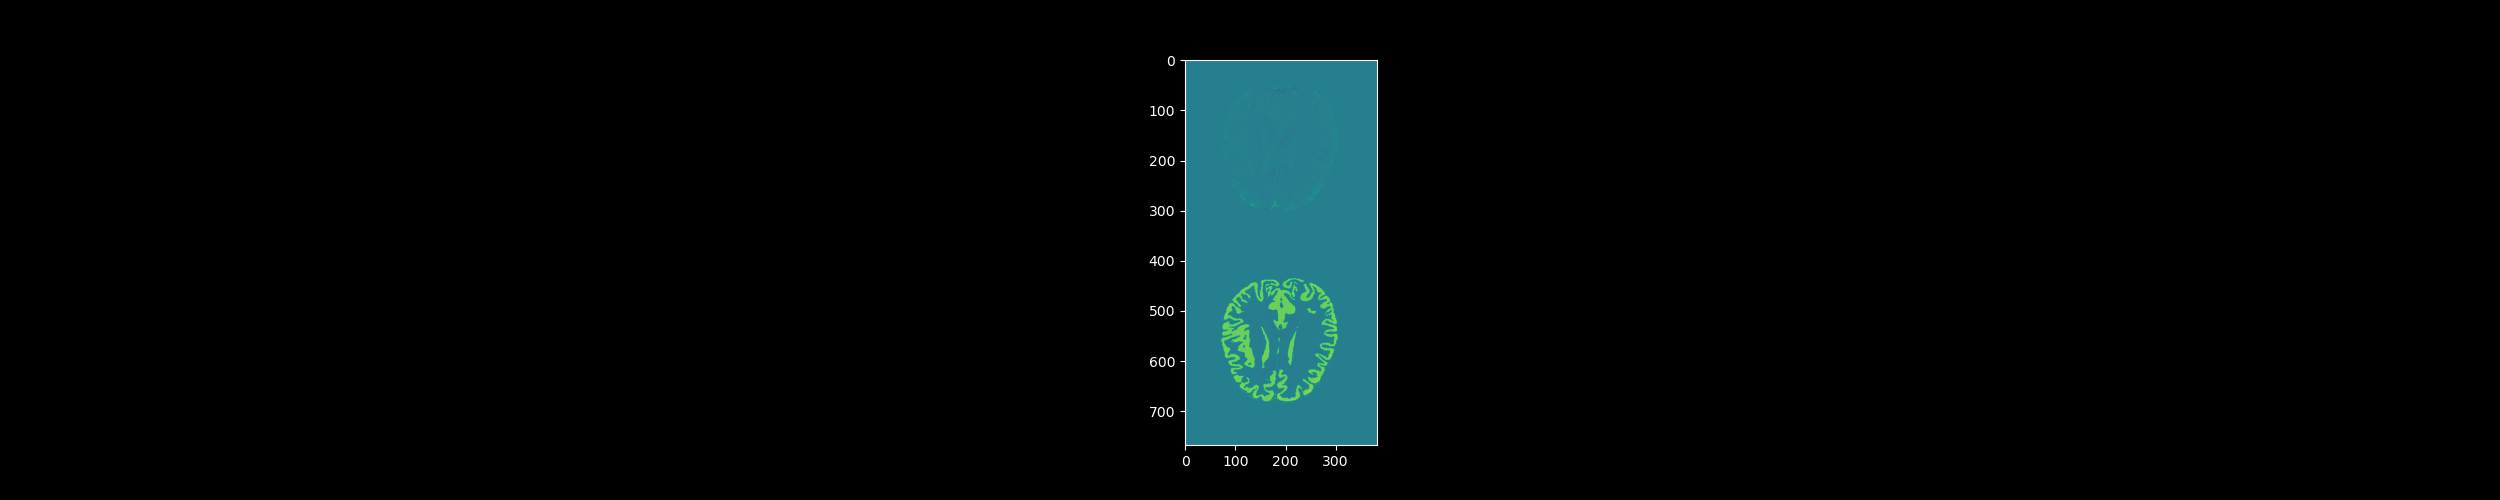

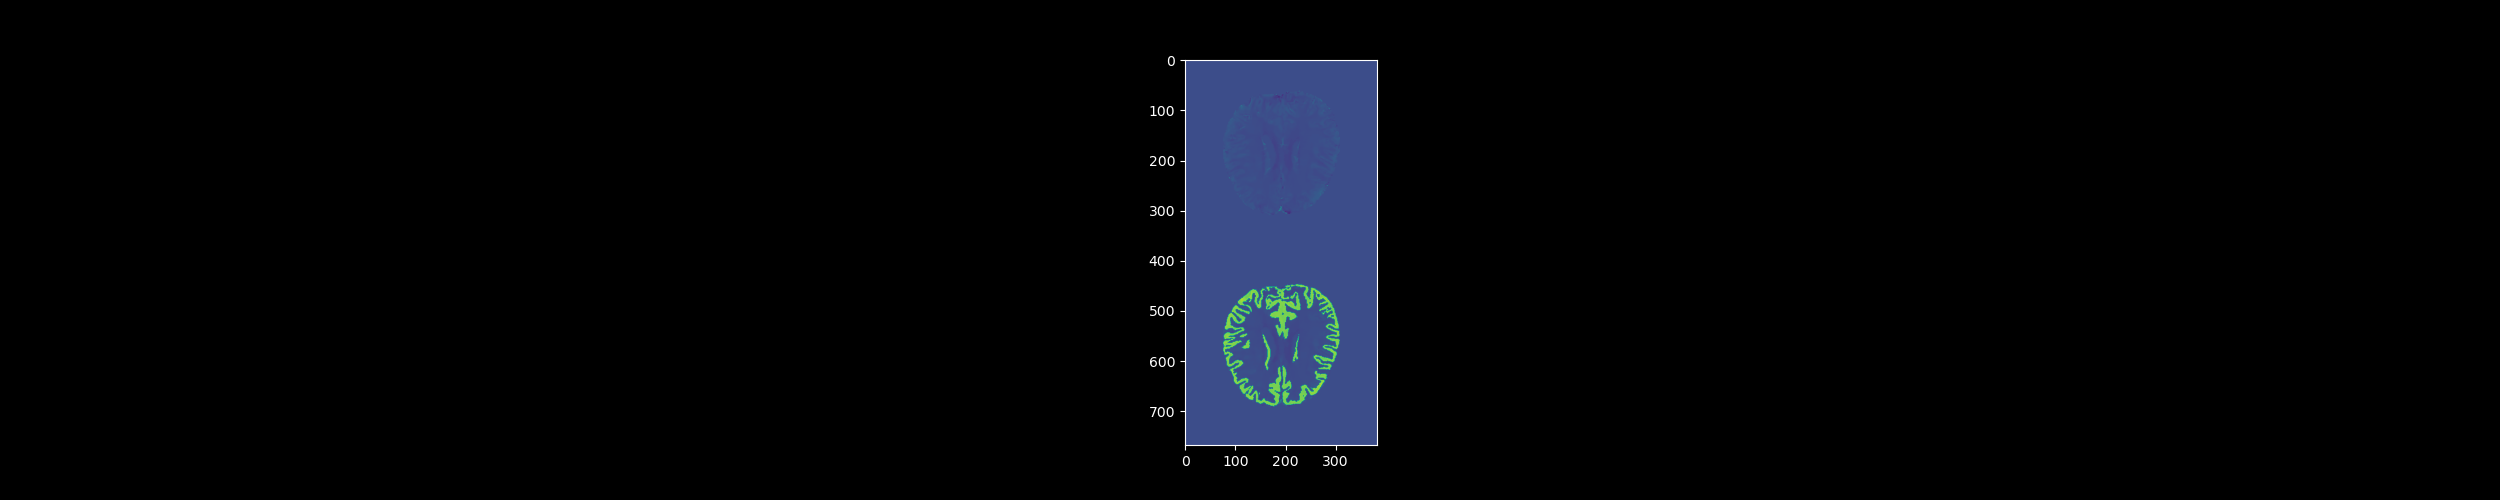

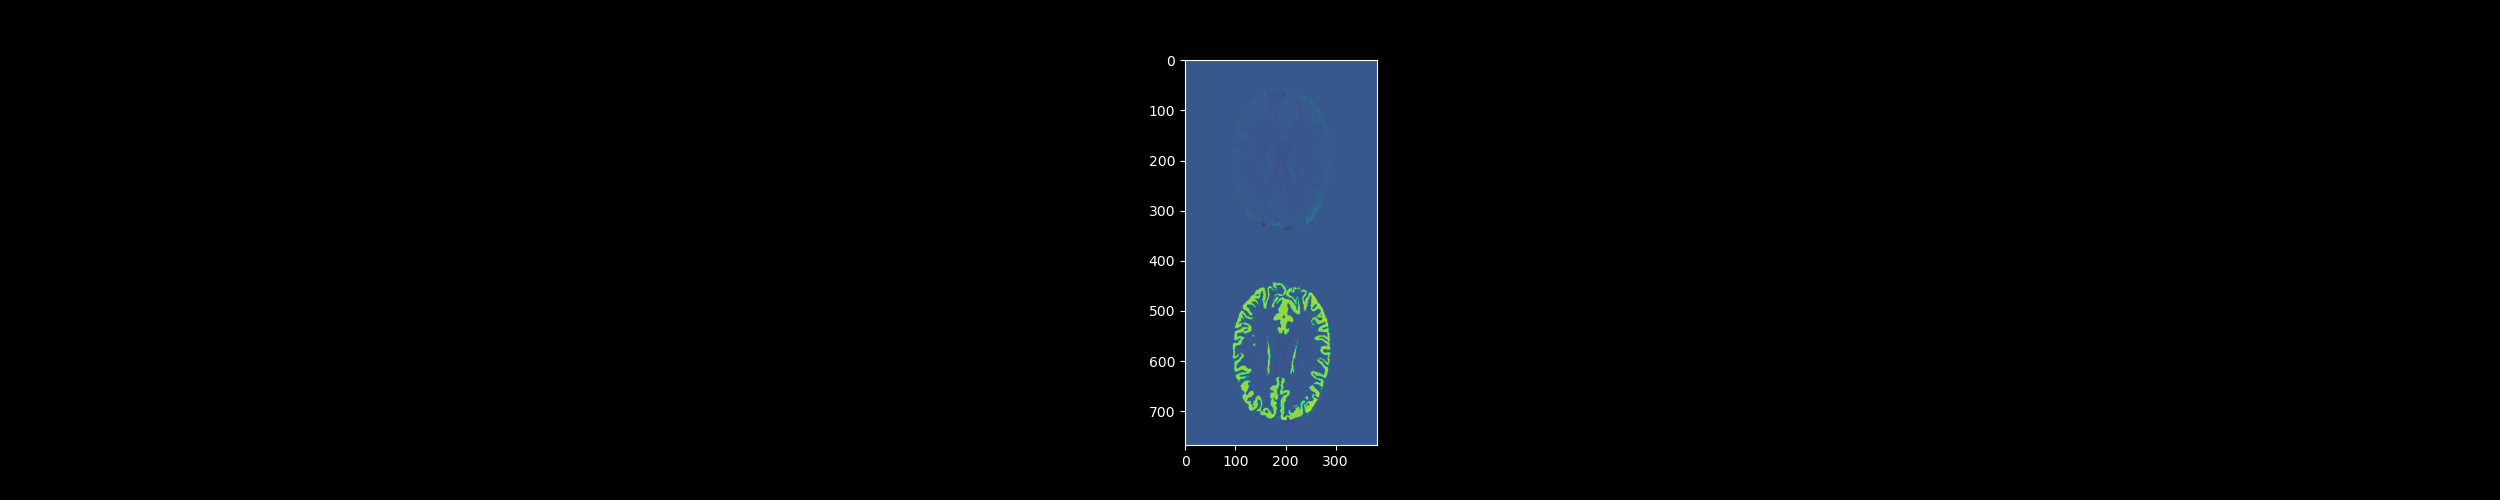

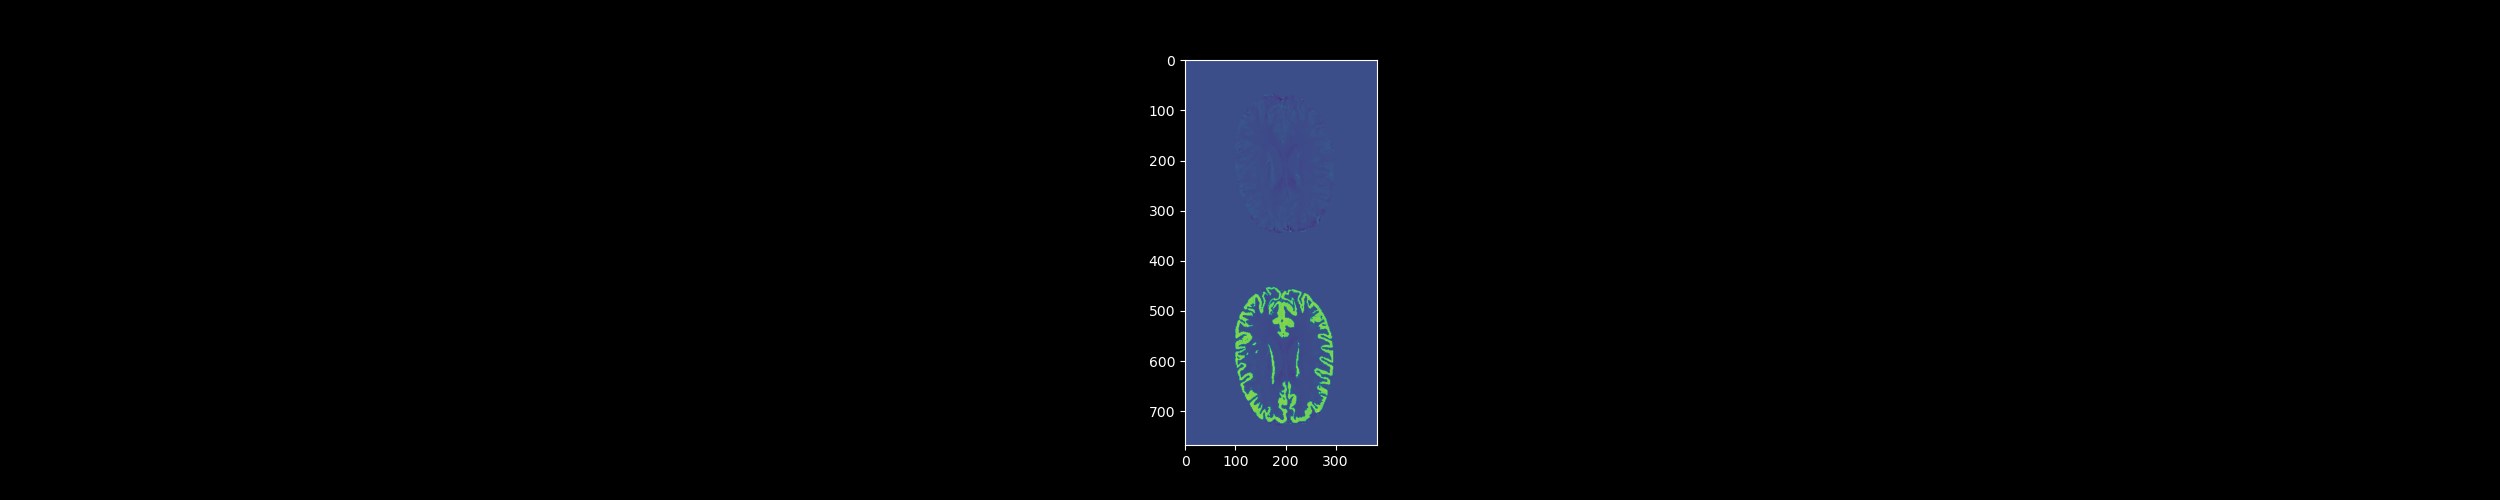

In [5]:
# Set window level
plt.close('all')
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
segs_15 = []
qsms_vsharp_15 = []
qsms_msmv_15 = []
voxel_sizes_15 = []
segs_3 = []
qsms_vsharp_3 = []
qsms_msmv_3 = []
voxel_sizes_3 = []
trackers = []
dir = '/media/mts_dbs/3t_15t'
files = os.listdir(dir)
n_cases = len(roi_15t_niis)
ms_vsharp = np.zeros((384,384,7))
ms_msmv = np.zeros((384,384,7))
ms_roi = np.zeros((384,384,7))
for j in np.arange(n_cases):
        seg_15 = nib.load(roi_15t_dir+roi_15t_niis[int(j)])
        vsharp_15 = nib.load(vsharp_15t_dir+vsharp_15t_niis[int(j)])
        msmv_15 = nib.load(msmv_15t_dir+msmv_15t_niis[int(j)])
        qsms_vsharp_15.append(np.asarray(vsharp_15.get_fdata()))
        qsms_msmv_15.append(np.asarray(msmv_15.get_fdata()))
        segs_15.append(np.asarray(seg_15.get_fdata()))
        voxel_size_15 = seg_15.header['pixdim'][1:4]
        voxel_sizes_15.append(voxel_size_15)

        seg_3 = nib.load(roi_3t_dir+roi_3t_niis[int(j)])
        vsharp_3 = nib.load(vsharp_3t_dir+vsharp_3t_niis[int(j)])
        msmv_3 = nib.load(msmv_3t_dir+msmv_3t_niis[int(j)])
        qsms_vsharp_3.append(np.asarray(vsharp_3.get_fdata()))
        qsms_msmv_3.append(np.asarray(msmv_3.get_fdata()))
        segs_3.append(np.asarray(seg_3.get_fdata()))
        voxel_size_3 = seg_3.header['pixdim'][1:4]
        voxel_sizes_3.append(voxel_size_3)

        if visualize == 1:
                multi_slice_viewer(np.hstack((qsms_vsharp_15[j].T+(segs_15[j].T/100),qsms_msmv_15[j].T+(segs_15[j].T))))
                multi_slice_viewer(np.hstack((qsms_vsharp_3[j].T+(segs_3[j].T/100),qsms_msmv_3[j].T+(segs_3[j].T))))


In [6]:
# Only extract ROI if it is present in all cases
seg_labels_all = segs_15[0]
for i in range(n_cases-1):
    seg_labels = np.intersect1d(segs_15[i],segs_15[i+1])
    seg_labels_all = np.intersect1d(seg_labels_all,seg_labels)

In [7]:
# Generate feature structure Phi from all ROIs and all cases
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()
extractor.enableFeatureClassByName('shape2D',enabled = False)

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.0972222089767456, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.0972222089767456, 'type': 'set_device_pixel_ratio'}


In [8]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

Phi_vsharp_15 = []
Phi_msmv_15 = []
Phi_vsharp_3 = []
Phi_msmv_3 = []
seg_labels = []
reextract = 1
x_vsharp_15 = []
x_msmv_15 = []
x_vsharp_3 = []
x_msmv_3 = []
keylib = []
roilib = []
loop_count = 0
n_rois = seg_labels_all[seg_labels_all>0].__len__()
roi_names = ['Background','Gray matter']
if reextract == 1:
    for i in range(n_cases):
        seg_sitk_15 = sitk.GetImageFromArray(segs_15[i])
        seg_sitk_15.SetSpacing(voxel_sizes_15[i].tolist())
        qsm_sitk_vsharp_15 = sitk.GetImageFromArray(qsms_vsharp_15[i])
        qsm_sitk_vsharp_15.SetSpacing(voxel_sizes_15[i].tolist())
        qsm_sitk_msmv_15 = sitk.GetImageFromArray(qsms_msmv_15[i])
        qsm_sitk_msmv_15.SetSpacing(voxel_sizes_15[i].tolist())

        seg_sitk_3 = sitk.GetImageFromArray(segs_3[i])
        seg_sitk_3.SetSpacing(voxel_sizes_3[i].tolist())
        qsm_sitk_vsharp_3 = sitk.GetImageFromArray(qsms_vsharp_3[i])
        qsm_sitk_vsharp_3.SetSpacing(voxel_sizes_3[i].tolist())
        qsm_sitk_msmv_3 = sitk.GetImageFromArray(qsms_msmv_3[i])
        qsm_sitk_msmv_3.SetSpacing(voxel_sizes_3[i].tolist())
        for j in seg_labels_all:
            if j>0:
                print('Extracting features for subject '+str(i)+' at the '+roi_names[int(j)]+' ROI')
                featureVector_vsharp_15 = extractor.execute(qsm_sitk_vsharp_15,seg_sitk_15,label=int(j))
                featureVector_msmv_15 = extractor.execute(qsm_sitk_msmv_15,seg_sitk_15,label=int(j))
                Phi_vsharp_15.append(featureVector_vsharp_15)
                Phi_msmv_15.append(featureVector_msmv_15)

                featureVector_vsharp_3 = extractor.execute(qsm_sitk_vsharp_3,seg_sitk_3,label=int(j))
                featureVector_msmv_3 = extractor.execute(qsm_sitk_msmv_3,seg_sitk_3,label=int(j))
                Phi_vsharp_3.append(featureVector_vsharp_3)
                Phi_msmv_3.append(featureVector_msmv_3)

                for key, value in six.iteritems(featureVector_vsharp_15):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_vsharp_15.append(featureVector_vsharp_15[key])
                        x_msmv_15.append(featureVector_msmv_15[key])
                        x_vsharp_3.append(featureVector_vsharp_3[key])
                        x_msmv_3.append(featureVector_msmv_3[key])
                        keylib.append(key)
                        roilib.append(seg_labels_all[np.mod(loop_count,n_rois)])
                        loop_count = loop_count+1
    
    X0_vsharp_15 = np.array(x_vsharp_15)
    X0_msmv_15 = np.array(x_msmv_15)
    X0_vsharp_3 = np.array(x_vsharp_3)
    X0_msmv_3 = np.array(x_msmv_3)
    np.save('X0_vsharp_15_gmm.npy',X0_vsharp_15)
    np.save('X0_msmv_15_gmm.npy',X0_msmv_15)
    np.save('X0_vsharp_3_gmm.npy',X0_vsharp_3)
    np.save('X0_msmv_3_gmm.npy',X0_msmv_3)
    K = np.asarray(keylib)
    np.save('K_gmm.npy',K)

    print('Saving VSHARP 1.5T feature vector')
    with open('Phi_vsharp_15_gmm', 'wb') as fp:  
        pickle.dump(Phi_vsharp_15, fp)

    print('Saving mSMV 1.5T feature vector')
    with open('Phi_msmv_15_gmm', 'wb') as fp: 
        pickle.dump(Phi_msmv_15, fp)

    print('Saving VSHARP 3T feature vector')
    with open('Phi_vsharp_3_gmm', 'wb') as fp:  
        pickle.dump(Phi_vsharp_3, fp)
    
    print('Saving mSMV 3T feature vector')
    with open('Phi_msmv_3_gmm', 'wb') as fp:  
        pickle.dump(Phi_msmv_3, fp)

else:
    X0_vsharp_15 = np.load('X0_vsharp_15_gmm.npy')
    X0_msmv_15 = np.load('X0_msmv_15_gmm.npy')
    X0_vsharp_3 = np.load('X0_vsharp_3_gmm.npy')
    X0_msmv_3 = np.load('X0_msmv_3_gmm.npy')
    K = np.load('K_gmm.npy')
    

Extracting features for subject 0 at the Gray matter ROI
Extracting features for subject 1 at the Gray matter ROI
Extracting features for subject 2 at the Gray matter ROI
Extracting features for subject 3 at the Gray matter ROI
Extracting features for subject 4 at the Gray matter ROI
Extracting features for subject 5 at the Gray matter ROI
Extracting features for subject 6 at the Gray matter ROI
Saving VSHARP 1.5T feature vector
Saving mSMV 1.5T feature vector
Saving VSHARP 3T feature vector
Saving mSMV 3T feature vector


In [9]:
with open('Phi_vsharp_15_gmm', 'rb') as fp:  
    Phi_vsharp_15 = pickle.load(fp)
    
with open('Phi_msmv_15_gmm', 'rb') as fp:  
    Phi_msmv_15 = pickle.load(fp)

with open('Phi_vsharp_3_gmm', 'rb') as fp:  
    Phi_vsharp_3 = pickle.load(fp)
    
with open('Phi_msmv_3_gmm', 'rb') as fp:  
    Phi_msmv_3 = pickle.load(fp)

In [10]:
n_roisc = Phi_vsharp_15.__len__()/n_cases

In [11]:
L = int(len(X0_vsharp_15)/n_cases)
n_features = int(L/n_rois)

In [12]:
X0_vsharp_15 = X0_vsharp_15.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X0_msmv_15 = X0_msmv_15.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X0_vsharp_3 = X0_vsharp_3.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X0_msmv_3 = X0_msmv_3.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
K_rs = K.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))

In [13]:
Mc = np.zeros((X0_vsharp_15.shape[1],X0_vsharp_15.shape[2]))
Mi = np.zeros((X0_vsharp_15.shape[1],X0_vsharp_15.shape[2]))
Mcv = np.zeros((X0_vsharp_15.shape[1],X0_vsharp_15.shape[2]))
Mcm = np.zeros((X0_vsharp_15.shape[1],X0_vsharp_15.shape[2]))
Kc = np.empty((X0_vsharp_15.shape[1],X0_vsharp_15.shape[2]),dtype=object)

In [14]:
def ccc(X01,X02):
    sigma1 = np.std(X01,axis = 0)
    sigma2 = np.std(X02,axis = 0)
    mu1 = np.mean(X01,axis = 0)
    mu2 = np.mean(X02,axis = 0)
    cov = np.mean((X01-mu1)*(X02-mu2),axis = 0)
    rho = cov/(sigma1*sigma2)
    rhoc = (2*rho*sigma1*sigma2)/(sigma1**2+sigma2**2+(mu1-mu2)**2)
    return rhoc

In [15]:
def icc(df):
    m = df.shape[0]
    k = df.shape[1]
    mu = np.nanmean(df)
    mu_j = df.mean(axis = 0)
    mu_i = df.mean(axis = 1)
    sT = (k/(m-1))*np.sum((mu-mu_i)**2)
    T = df
    sE = np.sum(np.sum((T-np.matlib.repmat(mu_i,k,1).T-np.matlib.repmat(mu_j,m,1)+mu)**2))/((m-1)*(k-1))
    rho = (sT-sE)/(sT+(k-1)*sE)
    return rho

In [16]:
def cv(X01,X02):
    sigma = np.std((X01,X02),axis = 0)
    mu = np.mean((X01,X02),axis = 0)
    cv = np.mean(sigma/mu)
    return cv

In [17]:
for i in np.arange(X0_vsharp_15.shape[1]):
    for j in np.arange(X0_vsharp_15.shape[2]):
        Mc[i,j] = ccc(X0_msmv_15[:,i,j],X0_msmv_3[:,i,j])
        Kc[i,j] = K_rs[1,i,j]

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [18]:
for i in np.arange(X0_vsharp_15.shape[1]):
    for j in np.arange(X0_vsharp_15.shape[2]):
        dataset = np.vstack((X0_msmv_15[:,i,j],X0_msmv_3[:,i,j]))
        Mi[i,j] = icc(dataset.T)

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [19]:
rho = Mc*Mi
Mc = Mc[~np.isnan(rho).any(axis = 1),:]
Mi = Mi[~np.isnan(rho).any(axis = 1),:]
#Kc = Kc[~np.isnan(rho).any(axis = 1),:]
rhoc = Mc*Mi

In [20]:
for i in np.arange(X0_vsharp_15.shape[1]):
    for j in np.arange(X0_vsharp_15.shape[2]):
        Mcv[i,j] = cv(X0_vsharp_15[:,i,j],X0_vsharp_3[:,i,j])
        Mcm[i,j] = cv(X0_msmv_15[:,i,j],X0_msmv_3[:,i,j])

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [21]:
Mcvc = Mcv[~np.isnan(Mcv+Mcm).any(axis = 1),:]
Mcmc = Mcm[~np.isnan(Mcv+Mcm).any(axis = 1),:]
Kcs = Kc[~np.isnan(Mcv+Mcm).any(axis = 1),:]

In [22]:
res = wilcoxon(Mcvc.ravel(),Mcmc.ravel())
res.statistic, res.pvalue

(337451.0, 0.16932542832828912)

In [23]:
np.median(Mcvc)

0.024069406976023132

In [24]:
np.median(Mcmc)

0.024029997487307404

In [25]:
np.sum(Mcvc < 0.1)/len(Mcv.ravel())

0.8495297805642633

In [26]:
np.sum(Mcmc < 0.1)/len(Mcm.ravel())

0.8545454545454545

In [27]:
idx_max_vsharp = abs(Mcvc).sum(axis=1).argsort()[::-1]
idx_min_vsharp = abs(Mcvc).sum(axis=1).argsort()[::1]

idx_max_msmv = abs(Mcmc).sum(axis=1).argsort()[::-1]
idx_min_msmv = abs(Mcmc).sum(axis=1).argsort()[::1]

In [28]:
n = 100
Kcs_max= np.intersect1d(idx_max_vsharp[1:n],idx_max_msmv[1:n])
Kcs_min = np.intersect1d(idx_min_vsharp[1:n],idx_min_msmv[1:n])

IndexError: index 1 is out of bounds for axis 1 with size 1

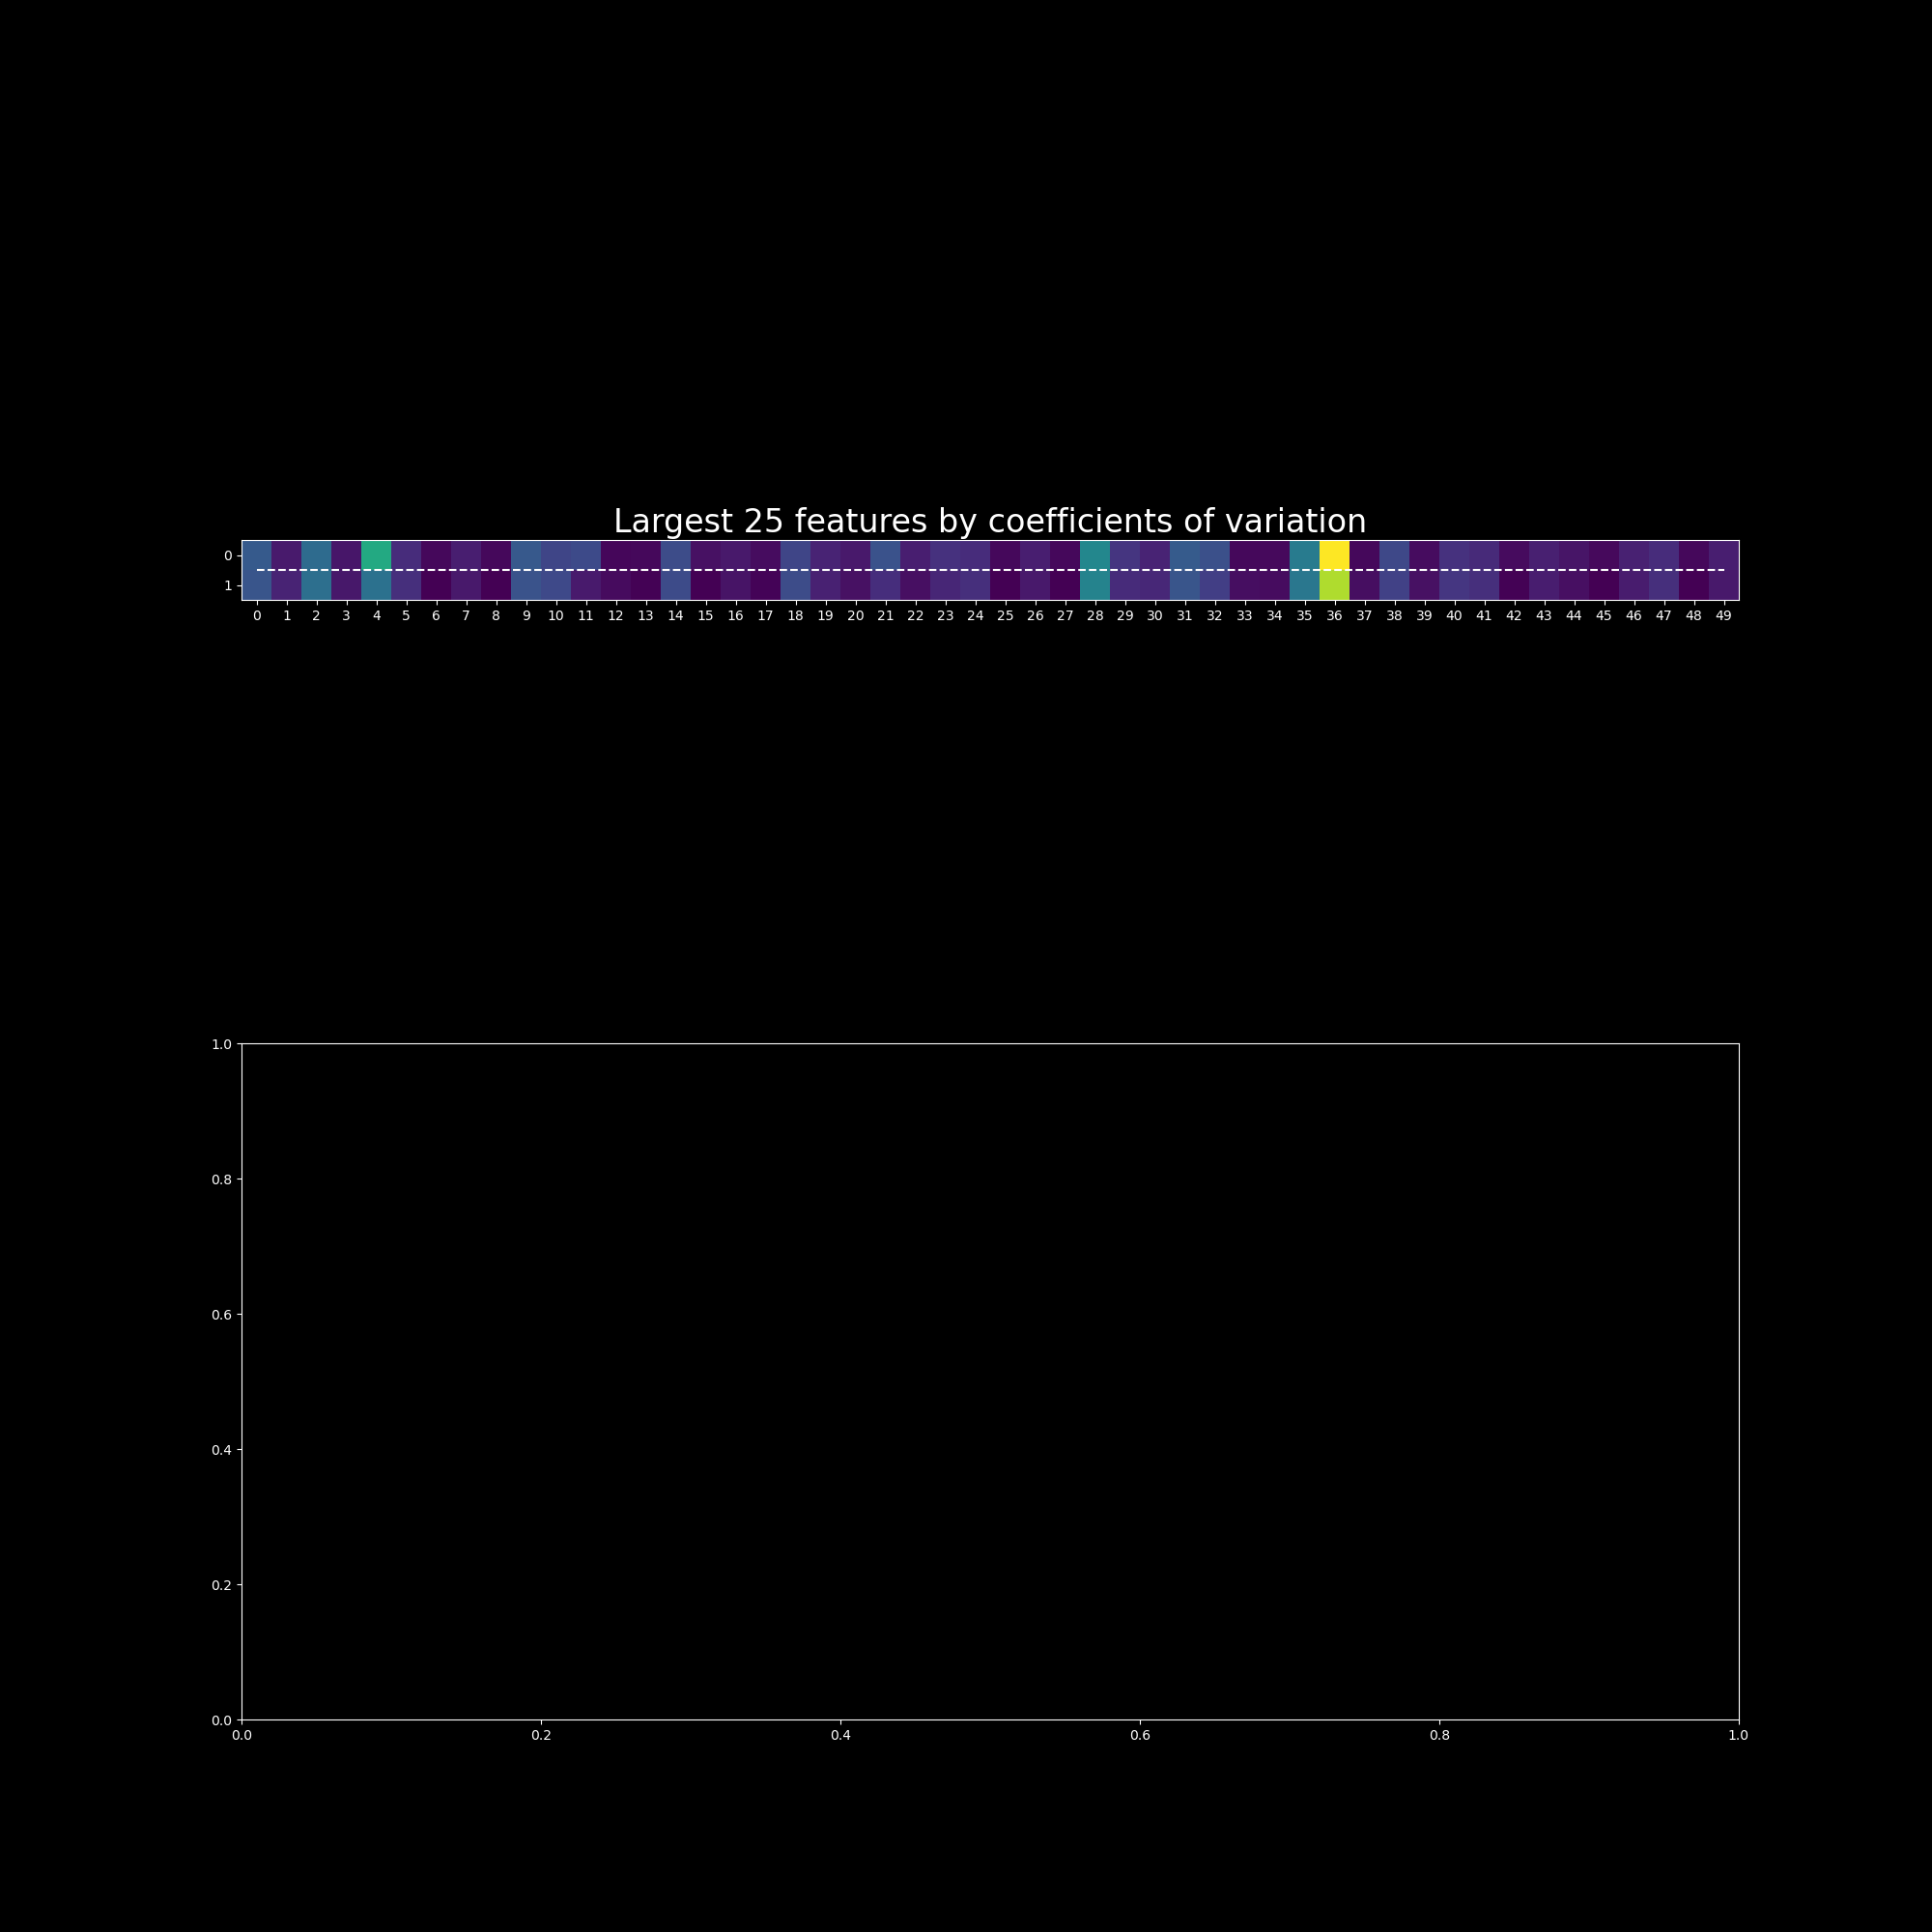

In [29]:
plt.close('all') 

fig, ax = plt.subplots(2,1,figsize = (20,20))

im = ax[0].imshow(np.vstack((abs(Mcvc)[Kcs_max[:n//2],:].T,abs(Mcmc)[Kcs_max[:n//2],:].T)),interpolation='nearest')
ax[0].hlines(n_rois-0.5,0,n//2-1, linestyle='dashed',color='white')
ax[0].set_title('Largest 25 features by coefficients of variation',fontsize=24)
ax[0].set_xticks(np.arange(Mcvc[idx_max_vsharp[:n//2]].shape[0]))
ax[0].set_yticks(np.arange(2*Mcvc[idx_max_vsharp[:n//2]].shape[1]))
ax[0].set_xticklabels(Kcs[Kcs_max[:n//2],1], rotation='vertical', fontsize=16)
ax[0].set_yticklabels(np.matlib.repmat(roi_names[:n_rois],2,1).ravel(),rotation='horizontal',fontsize=16)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')

im = ax[1].imshow(np.vstack((abs(Mcvc)[Kcs_min[:n//2],:].T,abs(Mcmc)[Kcs_min[:n//2],:].T)),interpolation='nearest')
ax[1].hlines(n_rois-0.5,0,n//2-1, linestyle='dashed',color='white')
ax[1].set_title('Smallest 25 features by coefficients of variation',fontsize=24)
ax[1].set_xticks(np.arange(Mcvc[idx_min_vsharp[:n//2]].shape[0]))
ax[1].set_yticks(np.arange(2*Mcvc[idx_min_vsharp[:n//2]].shape[1]))
ax[1].set_xticklabels(Kcs[idx_min_vsharp[:n//2],1], rotation='vertical', fontsize=16)
ax[1].set_yticklabels(np.matlib.repmat(roi_names[:n_rois],2,1).ravel(),rotation='horizontal',fontsize=16)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
Kcs = np.empty((Mc.shape[0],Mc.shape[1]),dtype=object)
im_type = np.empty((Mc.shape[0],Mc.shape[1]),dtype=object)
feat_class = np.empty((Mc.shape[0],Mc.shape[1]),dtype=object)

rhoc_exp = []
lbp_count = 0
log_count = 0
orig_count = 0
square_count = 0
squareroot_count = 0
wavelet_count = 0
for i in np.arange(Mc.shape[0]):
    for j in np.arange(Mc.shape[1]):
        feat_class[i,j] = Kc[i,j].rsplit('_',2)[1]
        im_type[i,j] = Kc[i,j].rsplit('_',2)[0]
        Kcs[i,j] = Kc[i,j].rsplit('_',1)[1]
        if im_type[i,j] == 'exponential':
            rhoc_exp.append(rhoc[i,j])
        if im_type[i,j] == 'lbp-3D-k':
            lbp_count = lbp_count+1
        if im_type[i,j] == 'logarithm':
            log_count = log_count+1
        if im_type[i,j] == 'original':
            orig_count = orig_count+1
        if im_type[i,j] == 'square':
            square_count = square_count+1
        if im_type[i,j] == 'squareroot':
            squareroot_count = squareroot_count+1
        if 'wavelet' in im_type[i,j]:
            wavelet_count = wavelet_count+1


In [ ]:
def filter_keys(d, keys):
    return {k: v for k, v in d.items() if keys not in k}

In [ ]:
def find_keys(d, keys):
    return {k: v for k, v in d.items() if keys in k}